# Lecture 8 - Low Dimensional Embedding

In this notebook we will learn how to embed date in low dimensions.

Below is the overview of this notebook.
<ol type = 1>
  <li> Use ResNet50 to compute image embeddings </li>
  <li>Compute low dimensional embeddings from image embeddings </li>
  <ol type = a>
  <li> PCA</li>
  <li> t-SNE</li>
  <li> UMAP</li>
  </ol>
  <li> Visualize Image Embeddings </li>
  <li> Cluster Embeddings </li>
  <li> Sample images from clusters </li>
</ol>


This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture08_LowDimensionalEmbedding.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

# Clones, imports, and GPU

## Using a GPU

If we switch the run-time to a GPU (graphical processing unit), the neural network computations will run faster.  To do this, go to the top left menu and select **Runtime-> Change runtime type -> Harware accelerator -> GPU**.  

The code below will tell you if your Colab runtime is using a GPU.

In [ ]:
# Check if GPU is available and set PyTorch to use the GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [ ]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2604, done.
remote: Counting objects: 100% (2604/2604), done.
remote: Compressing objects: 100% (2208/2208), done.
remote: Total 2604 (delta 400), reused 2594 (delta 391), pack-reused 0
Receiving objects: 100% (2604/2604), 168.01 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (400/400), done.
Updating files: 100% (1970/1970), done.


## Mount Google Drive

For your projects you may have a big folder of images or a big file of tweets.  You can put them in your Google Drive, and then access them through a Colab notebook by mounting your Google Drive.  The code below does that.  Run this after you clone the course GitHub repo.

**Note** We do not need to mount any drives today since all data is in the GitHub repo.

In [ ]:
from google.colab import drive
drive.mount('/content/social_media_analytics/drive')
#For Project, use the actual pictures in your drive. Just copy and paste the link

Mounted at /content/social_media_analytics/drive


## Import Packages

UMAP does not come pre-installed in Colab :(

In [ ]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import math
import json, re, os
import random

#Instagram analysis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from PIL import Image as PILImage
from matplotlib.patches import Ellipse

#Image processing with Resnet
import torch
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler

#Low dimensional embedding algorithms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

#Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#display settings for figures
pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
plt.rcParams['figure.figsize'] = [8, 6]


# Image Analysis

The Instagram images were downloaded using the Chrome extension Mass. Downloader: https://chromewebstore.google.com/detail/mass-downloader-for-insta/ldoldiahbhnbfdihknppjbhgjngibdbe


#scrap the data and delete the videos. Save images to your google drive

## Load ResNet

ResNet50 is a large neural network we can use to compute embeddings for the images.  We will discuss ResNets in a future lecture.  For now, you can read about it here: https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758.  

The code here will load the resnet neural network and put it onto your GPU if you have one.

In [ ]:
# Load the pretrained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.to(device)
# We're only interested in the embedding, so let's remove the final layer
resnet.fc = torch.nn.Identity()

# Ensure the model is in evaluation mode
resnet.eval()

# Define image transformations for neural network
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


## Image Processing Functions

The code here has a function `embed_images` that will compute an embedding of an image from its file path. There are also some other helpful image processing functions here as well

In [ ]:
# Function to compute embedding vector for all images in file_list
def embed_images(file_list):
    features = []
    for cnt,img_file in enumerate(file_list):
        if cnt % 100 == 0:
            print(f"{cnt}/{len(file_list)} images processed..")
        if img_file.endswith(('png', 'jpg', 'jpeg')):
            img = Image.open(img_file).convert('RGB')
            img_t = transform(img)
            batch_t = torch.unsqueeze(img_t, 0)
            batch_t = batch_t.to(device)
            with torch.no_grad():
                out = resnet(batch_t)
            features.append(out.cpu().flatten().numpy())
    return np.array(features)

# Function to load image from path and downsample it so plots are faster
def loadImage(path, max_size = 100):
    """Resize the image to a maximum dimension of max_size and apply zoom."""
    with PILImage.open(path) as img:
        # Calculate new size, maintaining aspect ratio
        aspect_ratio = img.width / img.height
        if aspect_ratio > 1:  # Width > height
            new_size = (int(max_size * aspect_ratio), max_size)
        else:
            new_size = (max_size, int(max_size / aspect_ratio))
        # Resize image
        img_resized = img.resize(new_size, PILImage.LANCZOS)
        # Convert to array for plt
        img_array = np.array(img_resized)
        # Apply zoom
        return img_array

## Load Image Paths

We need to load up the paths of the images we will analyze into the list `image_paths`.  We also sort this list by the filename since a larger value for the filename indicates a more recent post.  This will come in handy later on.

In [ ]:
# Path to your image folder
image_folder = 'data/image_compressed_taylorswift'

image_paths = [os.path.join(image_folder, img_file) for img_file in os.listdir(image_folder) if img_file.endswith(('png', 'jpg', 'jpeg'))]

# Function to extract the large number at the beginning of the filename
def extract_number(filepath):
    # Extract the filename from the filepath
    filename = os.path.basename(filepath)
    # Match the pattern: the number at the beginning of the filename before the first underscore
    match = re.search(r'^(\d+)_', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 or some default value if no number is found

# Sort the list by the extracted number
image_paths.sort(key=lambda x: extract_number(x))


print(image_folder)
print(f"{len(image_paths)} images")

#dataframe with image info.
df = pd.DataFrame({'image_path':image_paths})

data/image_compressed_taylorswift
901 images


## Compute Image Embedding

We will compute the embedding of the images using the ResNet50 neural network.  We do this using the `embed_images` function.  We save the embedding vectors  `resnet_embedding`.

In [ ]:
%%time
# Compute embedding using resnet
resnet_embedding = embed_images(image_paths)

# Standardize features
resnet_embedding = StandardScaler().fit_transform(resnet_embedding)
print(f"Shape of resnet embedding matrix is {resnet_embedding.shape}")

0/901 images processed..
100/901 images processed..
200/901 images processed..
300/901 images processed..
400/901 images processed..
500/901 images processed..
600/901 images processed..
700/901 images processed..
800/901 images processed..
900/901 images processed..
Shape of resnet embedding matrix is (901, 2048)
CPU times: user 12.1 s, sys: 254 ms, total: 12.4 s
Wall time: 13.1 s


## Compute Low Dimensional Embeddings

PCA, t-SNE, UMAP

### PCA

In [ ]:
%%time
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(resnet_embedding)


CPU times: user 79.3 ms, sys: 36.6 ms, total: 116 ms
Wall time: 137 ms


### t-SNE

In the t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm, the `init` parameter specifies the initialization method for the low-dimensional embedding. Initializing the embedding can significantly affect the algorithm's convergence and the quality of the resulting visualization. The `init` parameter can take several values, but in the context of your question, it is set to `'pca'`. Here's what it means:

- **`'pca'`**: This option initializes the embedding using the first few principal components obtained from a Principal Component Analysis (PCA) of the high-dimensional data. Specifically, when `n_components=2`, the first two principal components are used. This method provides a deterministic starting point for the optimization process and can help t-SNE converge faster and possibly to a better local minimum by aligning the initial embedding in the direction of greatest variance in the data. It is particularly useful for datasets with a lot of features, as it can reduce the computational burden by effectively summarizing the dataset's structure in fewer dimensions before t-SNE is applied.

Other common values for `init` include:
- **`'random'`**: The embedding is initialized randomly. This approach can lead to different results on different runs of the algorithm, especially on complex datasets or when the perplexity parameter is not optimally tuned. While random initialization can sometimes find good embeddings, it may also result in slower convergence or less optimal embeddings compared to more informed initialization methods like PCA.

Choosing between `'pca'` and `'random'` for the `init` parameter depends on the specific characteristics of your dataset and your computational resources. For many applications, starting with PCA (`'pca'`) is a good choice because it leverages the global structure of the data to provide a meaningful initial embedding, potentially leading to more stable and interpretable results.

In [ ]:
%%time
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca')
tsne_embedding = tsne.fit_transform(resnet_embedding)


CPU times: user 8.95 s, sys: 149 ms, total: 9.1 s
Wall time: 9.07 s


### UMAP

In UMAP (Uniform Manifold Approximation and Projection), `min_dist` is a parameter that controls the tightness of UMAP’s embedding. More specifically, it influences how close points can be in the low-dimensional representation provided by UMAP. This parameter plays a crucial role in determining the visual appearance of the clusters in the resulting plot.

- **High `min_dist` Values**: Setting a higher `min_dist` encourages UMAP to spread out points more uniformly across the embedding space. This can make clusters less tightly packed and potentially easier to distinguish, but it might also spread points within a cluster farther apart, making the cluster structure less apparent.

- **Low `min_dist` Values**: Conversely, setting a lower `min_dist` allows points to be closer to each other in the low-dimensional space, leading to tighter clusters. This can be particularly useful for visualizing and identifying dense clusters in the data. However, if the value is too low, different clusters might overlap significantly, especially if they are close in the high-dimensional space.

The `min_dist` parameter works in conjunction with the `n_neighbors` parameter:
- `n_neighbors` determines how UMAP balances local versus global structure in the data, with higher values favoring global structure.
- `min_dist` fine-tunes the representation’s granularity and separation between individual data points and clusters in the embedding.

Choosing the right value for `min_dist` (and `n_neighbors`) depends on the specific dataset and the goals of the analysis. For exploratory data analysis, it might be useful to experiment with different values to see how they affect the visualization and the separation of clusters in the embedded space.

In [ ]:
%%time
umap = UMAP(n_components = 2,
            n_neighbors=10,
            min_dist=0.1,
            metric='euclidean')
umap_embedding = umap.fit_transform(resnet_embedding)


CPU times: user 12.5 s, sys: 200 ms, total: 12.7 s
Wall time: 11.9 s


## Add Embeddings to Dataframe

We can add the different embeddings as x and y coordinates to `df`.  

**Optional:** At this point you can save `df` if you want to continue analysis later without having to recompute the image embeddings again.

In [ ]:
df['pca_x'] = pca_embedding[:,0]
df['pca_y'] = pca_embedding[:,1]
df['tsne_x'] = tsne_embedding[:,0]
df['tsne_y'] = tsne_embedding[:,1]
df['umap_x'] = umap_embedding[:,0]
df['umap_y'] = umap_embedding[:,1]

In [ ]:
df.to_csv('data/lecture_08_lde.csv', index = False)
#saves to database

## PCA Explanation of Variance

We can look at how many PCA components we need to explain most of the variance in the data.

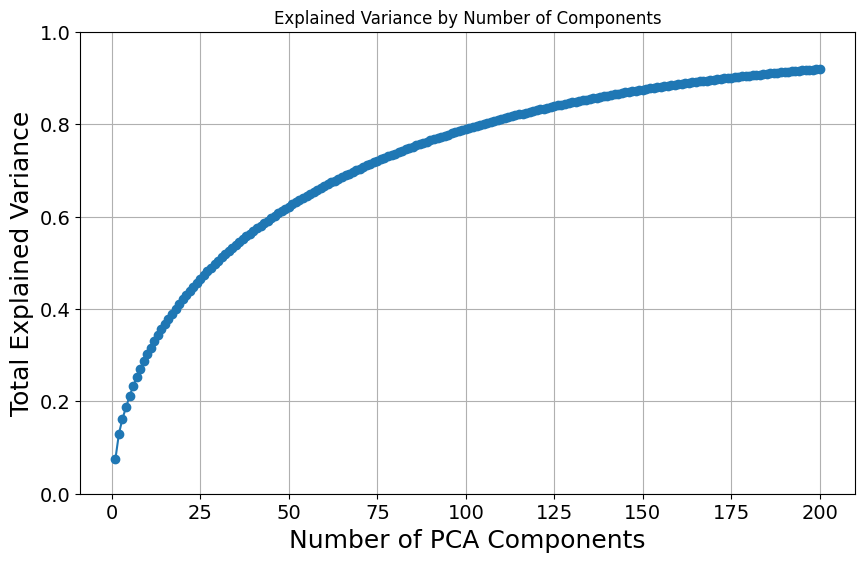

In [ ]:
# Range of components to consider
n_components = 200

pca = PCA(n_components=n_components)
pca.fit(resnet_embedding)
explained_variances = np.cumsum(pca.explained_variance_ratio_)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1,n_components+1), explained_variances,
         marker='o')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of PCA Components')
plt.ylabel('Total Explained Variance')
plt.ylim(0,1)
plt.grid()
plt.show()


## Plot Image Embeddings

We can plot mini-versions of the images at the embedding locations for each embedding type (PCA, t-SNE, UMAP).  Use the `plot_image_embedding` function to do this.  You need to specify the column names for the `x` and `y` embedding coordinates, and the `image_zoom` you want.  If there are more images, you should use a smaller zoom.

In [ ]:
#this plots mini versions of the images in a scatter plot (uses a lot of RAM, so be careful)
def plot_image_embedding(df, col_x,col_y,
                         image_zoom = 0.3, #if 900 pics, then try 0.1-0.2
                         max_size = 100):

  x = df[col_x]
  y = df[col_y]
  image_paths = df['image_path']

  fig, ax = plt.subplots(figsize = (10,10))
  ax.scatter(x, y)  # Plotting just for the base scatter plot

  for x0, y0, path in zip(x, y, image_paths):
      img = loadImage(path, max_size)
      ab = AnnotationBbox(OffsetImage(img,
                                      zoom = image_zoom),
                          (x0, y0),
                          frameon=False)
      ax.add_artist(ab)

  return ax

#UMAP is probably the best!

In [ ]:
%%time
embedding_names = ['pca','tsne','umap']
image_zoom = 0.2
for embedding_name in embedding_names:
  col_x, col_y = f'{embedding_name}_x', f'{embedding_name}_y'
  ax = plot_image_embedding(df, col_x,col_y, image_zoom)
  ax.set_title(embedding_name)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Plot Embedding By Age

The image files are saved from oldest to newest.  We can define an `age` for an image as the length of `df` minus its index in `df`.  This way the first image, which is the oldest, has the largest age.  Then we can do a `scatterplot` of the imaged embeddings and color the markers by their `age`.  This lets us see if there is any temporal evolution to what is being posted.

In [ ]:
df['age'] = len(df) - np.array(df.index)

In [ ]:
marker_size = 10
embedding_name = 'umap'

xcol, ycol = f'{embedding_name}_x', f'{embedding_name}_y'
# Normalize the age for color mapping
df['normalized_age'] = (df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min())

# Create a plot with Plotly
fig = px.scatter(df, x=xcol, y=ycol,
                 color='normalized_age',
                 color_continuous_scale='RdBu',  # Red to Blue color scale, but you can use "blue_to_red" from your custom cmap
                 hover_name='age',  # Shows age on hover
                 size_max=100,  # Adjust the maximum marker size
                 title='Image Embeddings Colored by Age',
                 custom_data=['age'])

# Update the color bar title
fig.update_layout(width=800,  # Width of 8 inches (800 pixels)
                  height=800,
                  coloraxis_colorbar=dict(title='Age'))
fig.update_traces(marker=dict(size=marker_size),
                  hovertemplate='age = %{customdata[0]}<extra></extra>')  # Set marker size to 20

# Show the figure
fig.show()


## Learn Optimal Number of Clusters
Calculate the silhouette score and intertia of the k-means clusters for different values of k.

In [ ]:
# Choose your embedding to cluster
embedding_name = 'umap'
embedding = df[[f'{embedding_name}_x', f'{embedding_name}_y']].to_numpy()

# Define the range of K values to try
K_range = range(2, 11)  # For example, trying K from 2 to 10

# Prepare a list to store silhouette scores
silhouette_scores = []

# Compute KMeans and silhouette score for each K
for K in K_range:
    kmeans = KMeans(n_clusters=K,
                    random_state=24,
                    n_init='auto')
    kmeans.fit(embedding)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(embedding, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {K}, silhouette score = {silhouette_avg}")

# Find the optimal K (number of clusters) with the highest silhouette score
optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The silhouette optimal number of clusters (K) is: {optimal_K}")





K = 2, silhouette score = 0.47215262055397034
K = 3, silhouette score = 0.49729758501052856
K = 4, silhouette score = 0.38316115736961365
K = 5, silhouette score = 0.39935383200645447
K = 6, silhouette score = 0.4038965106010437
K = 7, silhouette score = 0.3943353295326233
K = 8, silhouette score = 0.4080547094345093
K = 9, silhouette score = 0.4116199016571045
K = 10, silhouette score = 0.414172887802124
The silhouette optimal number of clusters (K) is: 3


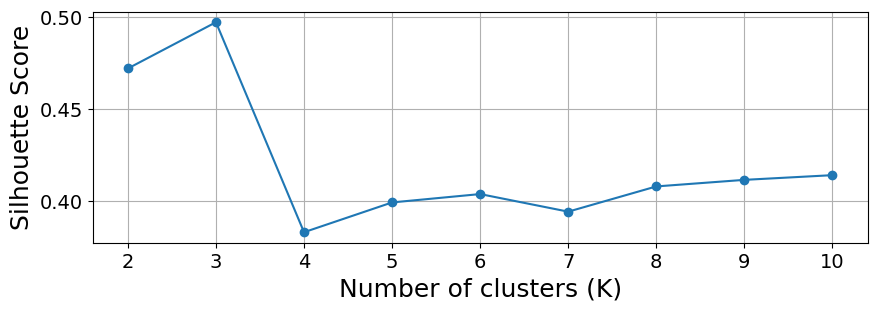

In [ ]:
# Plot silhouette scores over K
plt.figure(figsize=(10, 3))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

## Calculate "Optimal" Clusters

Sometimes the silhouette score does not give us a good number of clusters.  In that case we can pick our own value, probably something larger than what the silhouette score suggests.

In [ ]:
optimal_K = 7 #this number depends on how your cluster comes out and you make a judgement call. In the graph above, 3 is the best with the highest amount. However, that means that there are less and the cat cluster might not show. So 7 might be good
kmeans = KMeans(n_clusters=optimal_K,
                random_state=24,
                n_init='auto')
kmeans.fit(embedding)
kmeans_labels = [str(x) for x in kmeans.labels_]
df['kmeans_label'] = kmeans_labels

### Plot size of clusters

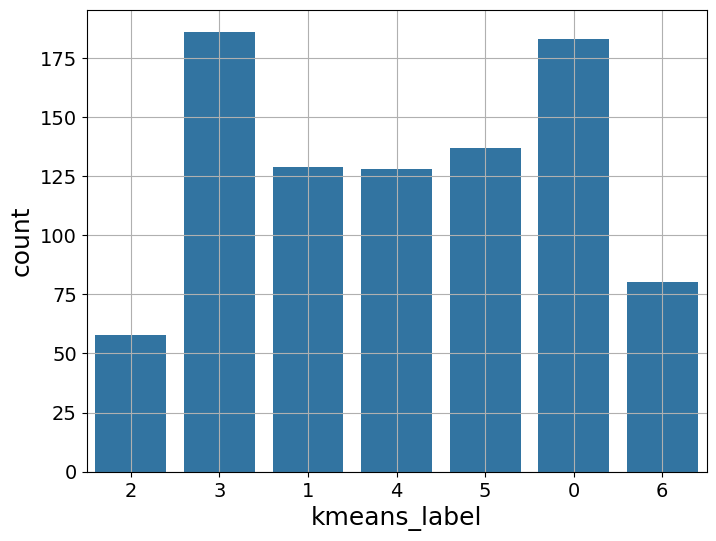

In [ ]:
sns.countplot(data = df, x = 'kmeans_label')
plt.grid()
#you can assume that cluster 2 is the cats based on the smaller count

### Plot Age of Clusters


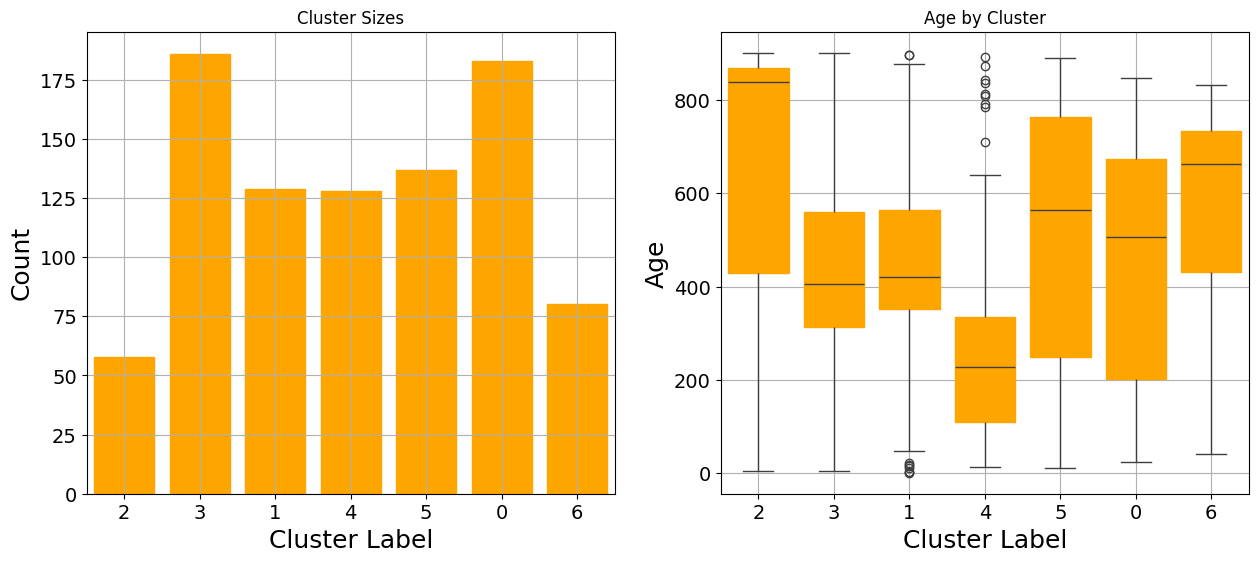

In [ ]:
# prompt: barplot and boxplor "kmeans_labels vs 'age' side by side  subplot. add a grid. make them orange.

import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Barplot of cluster sizes
sns.countplot(data=df, x='kmeans_label', ax=ax1)
ax1.grid()
ax1.set_title('Cluster Sizes')
ax1.set_xlabel('Cluster Label')
ax1.set_ylabel('Count')

# Boxplot of age by cluster
sns.boxplot(x='kmeans_label', y='age', data=df, ax=ax2)
ax2.grid()
ax2.set_title('Age by Cluster')
ax2.set_xlabel('Cluster Label')
ax2.set_ylabel('Age')

# Set the color of the bars and boxes to orange
for patch in ax1.patches:
    patch.set_color('orange')
for patch in ax2.patches:
    patch.set_color('orange')

# Display the plot
plt.show()


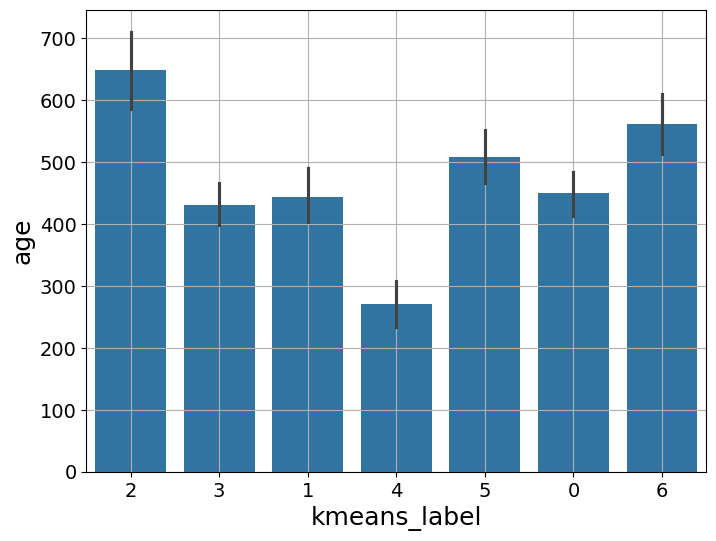

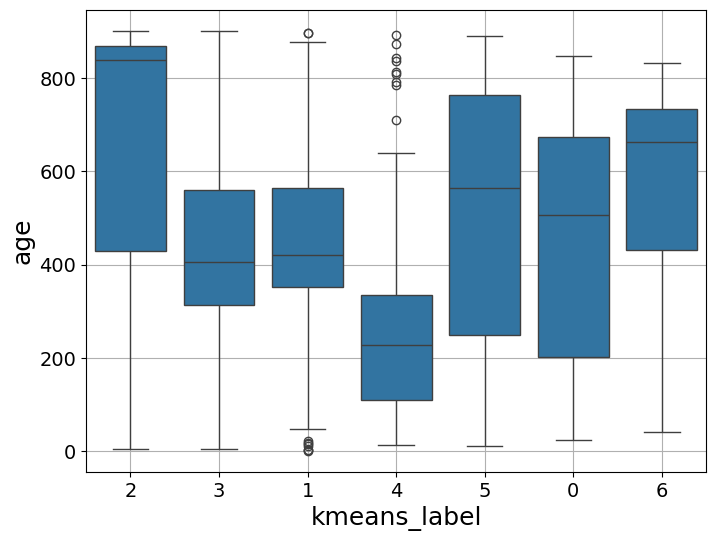

In [ ]:
sns.barplot(data = df,
            x = 'kmeans_label',
            y = 'age')
plt.grid()
plt.show()
sns.boxplot(data = df,
            x = 'kmeans_label',
            y = 'age')
plt.grid()
plt.show()

## Plot Clusters

To visualize the clusters, we can plot the image embeddings as we did before with the `plot_image_embedding` function, and then we can draw ellispes around each cluster with the `draw_ellipse` function.

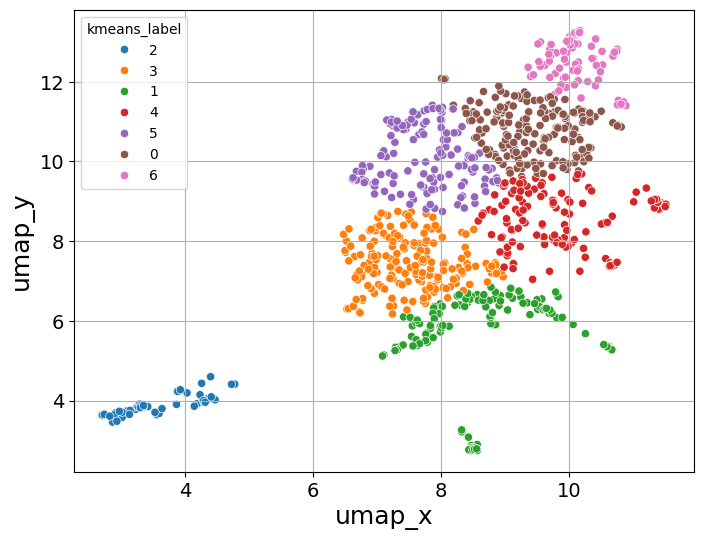

In [ ]:
sns.scatterplot(data = df ,
                x='umap_x',
                y = 'umap_y',
                hue = 'kmeans_label')
plt.grid()
plt.show()

In [ ]:
# Function to draw ellipses
def draw_ellipse(position, covariance, ax=None,
                 ellipse_scale=5, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = ellipse_scale * np.sqrt(s)
    else:
        angle = 0
        width, height = ellipse_scale * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 2):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle = angle, **kwargs))

,age,umap_x,umap_y
kmeans_label,,,
4,270.203125,9.861684,8.528664
3,430.338710,7.502943,7.441734
1,443.813953,8.617638,5.605345
0,449.650273,9.423208,10.783582
5,508.474453,7.763073,10.046520
6,561.475000,10.133562,12.505451
2,648.362069,3.548056,3.862269


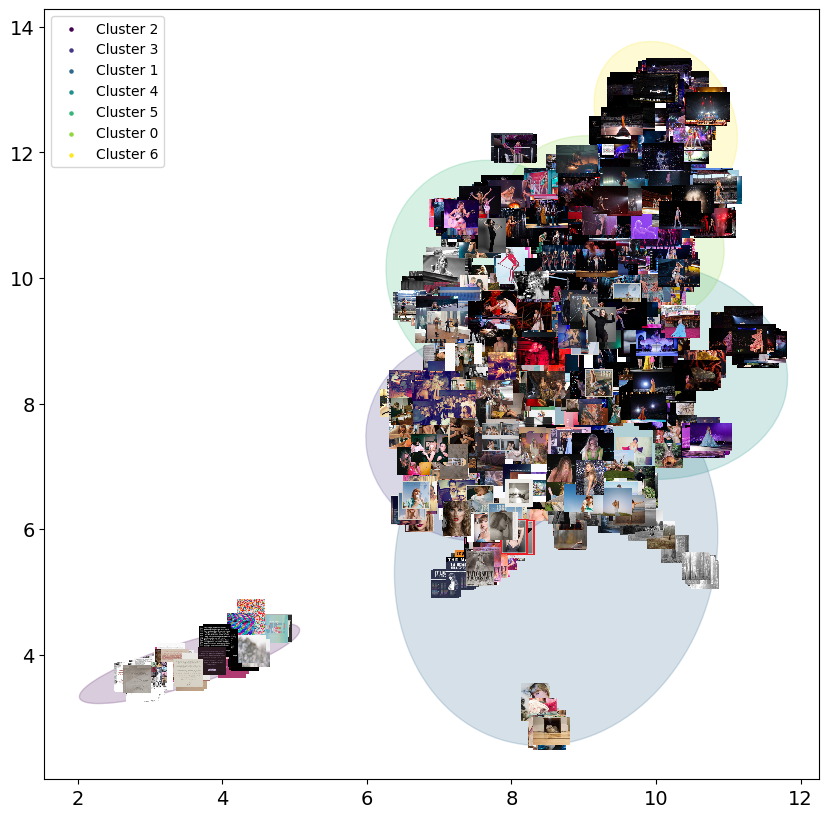

CPU times: user 10.3 s, sys: 203 ms, total: 10.5 s
Wall time: 10.6 s


In [ ]:
%%time
ellipse_scale = 5
image_zoom = 0.2

# Print out mean age of each cluster
display(df.groupby(by = 'kmeans_label')[['age','umap_x','umap_y']].mean().sort_values(by = 'age'))

# Plot images
xcol, ycol = f'{embedding_name}_x', f'{embedding_name}_y'
ax = plot_image_embedding(df, xcol, ycol, image_zoom)



# Plot ellipses for each cluster
colors = plt.cm.viridis(np.linspace(0, 1, len(df['kmeans_label'].unique())))
for k, col in zip(df['kmeans_label'].unique(), colors):
    data_k = df[df['kmeans_label'] == k]
    x_k, y_k = data_k[xcol], data_k[ycol]
    ax.scatter(x_k, y_k, s=5, color=col, label=f'Cluster {k}')

    # Calculate the mean and covariance matrix for the cluster
    cov = np.cov(x_k, y_k)
    draw_ellipse([np.mean(x_k), np.mean(y_k)], cov,
                 ax=ax,
                 ellipse_scale = ellipse_scale,
                 alpha=0.2, color=col)

ax.legend()
plt.show()


## Plot Samples of Images From Clusters

We can sample some images from each cluster using the `sample()` function and plot them in a nice grid.  This lets us see what is the general style of images in a cluster.  We just need to pick `nsamples` the number of samples, and `ncols` the number of columns in our image grid.  

In [ ]:
%%time
nsamples = 12  #numer of samples per cluster
max_size = 150  #width of image
ncols = 4  #number of columsn in image grid

clusters = np.sort(df['kmeans_label'].unique())

for cluster in clusters:
  df_cluster = df[df['kmeans_label'] == cluster]
  print(f"\n\nCluster {cluster}: has {len(df_cluster)} images")
      # Calculate the number of rows needed for the nx4 grid

  nrows = math.ceil(nsamples / ncols)

  # Create a figure with subplots
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                          figsize=(9, 9))
  fig.suptitle(f'Cluster {cluster}', fontsize=16)

  # Flatten the axis array for easy indexing
  axs = axs.ravel()

  # Hide unused subplots if nsamples is not a multiple of 4
  for i in range(nsamples, len(axs)):
      axs[i].axis('off')

  # Plot each sample
  for idx, (i, row) in enumerate(df_cluster.iterrows()):
      if idx >= nsamples:
          break
      img_path = row['image_path']
      #img = Image.open(img_path)
      img = loadImage(img_path, max_size)
      axs[idx].imshow(img)
      axs[idx].set_title(f"Sample {i}", fontsize=18)
      axs[idx].axis('off')  # Hide the axis

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
  plt.show()



Output hidden; open in https://colab.research.google.com to view.